In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd 
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from unidecode import unidecode

import xarray as xr
import warnings

# For plotting
from matplotlib.colors import ListedColormap
custom_palette = sns.color_palette("Paired", 12)
my_cmap = ListedColormap(custom_palette.as_hex())

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

warnings.filterwarnings("ignore", category=DeprecationWarning) 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1 Read historical wheat data 
- for Argentina on municipality level, from 1969-2022 (https://datosestimaciones.magyp.gob.ar/)

In [2]:
df = (pd
      .read_csv("files/crop data/historical_wheat_data_argentina.csv", encoding="latin-1", sep=";")
      .drop(columns={"Cultivo", "idProvincia", "idDepartamento", "Sup. Sembrada"}))

df.columns = ["year", "province", "municipality", "harvested area [ha]", "production [t]", "yield [kg/ha]"]
df["year"] = df["year"].str[:4].astype(int)

# Add name column
df["province"] = df["province"].str.lower().apply(lambda x: unidecode(x))
df["municipality"] = df["municipality"].str.lower().apply(lambda x: unidecode(x))
# Rename one instance of municipality to match with region names in section 3
df["municipality"] = df["municipality"].replace("coronel de marina l rosales", "coronel de marina leonardo rosales")
df["name"] = df["province"] + " " + df["municipality"]
df = df[["year", "province", "municipality", "name", "production [t]", "harvested area [ha]", "yield [kg/ha]"]]

df.head(2)

,year,province,municipality,name,production [t],harvested area [ha],yield [kg/ha]
0,1969,buenos aires,25 de mayo,buenos aires 25 de mayo,71400,42000,1700
1,1970,buenos aires,25 de mayo,buenos aires 25 de mayo,54000,36000,1500


### 2. Filter relevant provinces & municipalities

#### 2.1 By highest production

In [3]:
production_by_province = df.groupby("province")["production [t]"].sum().reset_index().sort_values(by="production [t]", ascending=False).reset_index(drop=True)
production_by_province["production cumsum [%]"] = np.round(100 * production_by_province["production [t]"] / production_by_province["production [t]"].sum()).cumsum()

df = df.loc[df["province"].isin(production_by_province.iloc[:5]["province"].unique())].reset_index(drop=True)

#### 2.2 By complete time series

In [5]:
complete_areas = (
    df.loc[df["year"].between(1993, 2016)]
    .groupby("name")
    .size()
    .reset_index(name="count")
    .loc[lambda x: x["count"] == 24, "name"]
    .unique()
    .tolist()
)

df = df.loc[df["name"].isin(complete_areas)].reset_index(drop=True)
df.head(2)

,year,province,municipality,name,production [t],harvested area [ha],yield [kg/ha]
0,1969,buenos aires,25 de mayo,buenos aires 25 de mayo,71400,42000,1700
1,1970,buenos aires,25 de mayo,buenos aires 25 de mayo,54000,36000,1500


In [7]:
df[["province", "municipality"]].drop_duplicates().shape

(142, 2)

### 3. Read agro-climate regions and preprocess

In [8]:
# Read file
regions = pd.read_excel("files/regions/cluster.xlsx")

# Remane columns
regions.columns = ["municipality", "province", "region", "regionID"]

# Remove "Departamento de " and "Partido de " from municipality names
regions["municipality"] = regions["municipality"].apply(lambda x: x.replace("Departamento de ", "").replace("Partido de ", ""))

# Add name column
regions["province"] = regions["province"].str.lower().apply(lambda x: unidecode(x))
regions["municipality"] = regions["municipality"].str.lower().apply(lambda x: unidecode(x))
regions["name"] = regions["province"] + " " + regions["municipality"]

# Filter relevant provinces
regions = regions.loc[regions["province"].isin(production_by_province.iloc[:5]["province"].unique())].reset_index(drop=True)

# Merge region information to df
region_yield = df.merge(regions[["name", "region", "regionID"]], on="name", how="left")
region_yield.head()

,year,province,municipality,name,production [t],harvested area [ha],yield [kg/ha],region,regionID
0,1969,buenos aires,25 de mayo,buenos aires 25 de mayo,71400,42000,1700,Pampa subhúmeda sur,6
1,1970,buenos aires,25 de mayo,buenos aires 25 de mayo,54000,36000,1500,Pampa subhúmeda sur,6
2,1971,buenos aires,25 de mayo,buenos aires 25 de mayo,39000,30000,1300,Pampa subhúmeda sur,6
3,1972,buenos aires,25 de mayo,buenos aires 25 de mayo,73600,41000,1795,Pampa subhúmeda sur,6
4,1973,buenos aires,25 de mayo,buenos aires 25 de mayo,9000,6000,1500,Pampa subhúmeda sur,6


### 4. Read shapefiles to visualize regions 

.. at the end of this notebook

In [10]:
# Read ADM1 shapefiles (province level - for visualization purposes)
gdf_adm1 = gpd.read_file("files/shapefiles/arg_admbnda_adm1_unhcr2017.shp").to_crs("EPSG:4326")

# Read ADM2 shapefiles (municipality level)
gdf_adm2 = gpd.read_file("files/shapefiles/arg_admbnda_adm2_unhcr2017.shp")
gdf_adm2["name"] = gdf_adm2["ADM1_ES"].str.lower().apply(lambda x: unidecode(x)) + " " + gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))

# Filter study-relevant municipalities 
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(complete_areas), ["ADM1_ES", "name", "geometry"]].reset_index(drop=True)

# Merge region information to gdf_adm2
region_polygons = gdf_adm2.merge(region_yield[["name", "region"]], on="name", how="left").dissolve(by="region")

# Export study-region to shapefile
region_polygons.to_file('files/shapefiles/study_region_v2.shp', driver='ESRI Shapefile')

#### 5. Aggregate municipality yield to regional and national level using harvested area

In [14]:
df_regional = (
    region_yield.assign(yield_weighted=region_yield["yield [kg/ha]"] * region_yield["harvested area [ha]"])
    .groupby(["region", "year"])
    .agg({"harvested area [ha]": "sum", "yield_weighted": "sum"})
    .assign(yield_kg_per_ha=lambda x: x["yield_weighted"] / x["harvested area [ha]"])
    .reset_index()
    .rename(columns={"yield_kg_per_ha": "yield [kg/ha]"})
    [["region", "year", "harvested area [ha]", "yield [kg/ha]"]]
)

df_regional.head(2)

,region,year,harvested area [ha],yield [kg/ha]
0,Chaco húmedo sur,1969,47000,968.170213
1,Chaco húmedo sur,1970,85000,1347.211765


In [15]:
df_national = (
    region_yield.assign(yield_weighted=region_yield["yield [kg/ha]"] * region_yield["harvested area [ha]"])
    .groupby(["year"])
    .agg({"harvested area [ha]": "sum", "yield_weighted": "sum"})
    .assign(yield_kg_per_ha=lambda x: x["yield_weighted"] / x["harvested area [ha]"])
    .reset_index()
    .rename(columns={"yield_kg_per_ha": "yield [kg/ha]"})
    [["year", "harvested area [ha]", "yield [kg/ha]"]]
)

df_national.head(2)

,year,harvested area [ha],yield [kg/ha]
0,1969,5084940,1360.855654
1,1970,3582000,1332.279726


### 6. Detrend

Using a 5-year centered rolling mean. Based on Iizumi et al. 2021 (https://doi.org/10.1175/WAF-D-20-0097.1)

In [16]:
df_national["rolling_mean_yield"] = df_national["yield [kg/ha]"].rolling(5, center=True).mean()
df_national = df_national.loc[df_national["year"].between(1993, 2016)].reset_index(drop=True)
df_national["yield anomaly [%]"] = 100 * (df_national["yield [kg/ha]"] - df_national["rolling_mean_yield"]) / df_national["rolling_mean_yield"]

df_regional["rolling_mean_yield"] = df_regional.groupby("region")["yield [kg/ha]"].transform(lambda x: x.rolling(5, center=True).mean())
df_regional = df_regional.loc[df_regional["year"].between(1993, 2016)].reset_index(drop=True)
df_regional["yield anomaly [%]"] = 100 * (df_regional["yield [kg/ha]"] - df_regional["rolling_mean_yield"]) / df_regional["rolling_mean_yield"]

#### 7. Estimate harvested area for each year
.. using the mean of all other years except the current one

In [30]:
df_regional["harvested area loo [ha]"] = df_regional.groupby("region")["harvested area [ha]"].transform(lambda x: round((x.sum() - x)/ len(x-1)))

In [51]:
df_regional.head(2)

,region,year,harvested area [ha],yield [kg/ha],rolling_mean_yield,yield anomaly [%],harvested area loo [ha]
0,Chaco húmedo sur,1993,37000,1913.756757,1882.869454,1.640438,64047.0
1,Chaco húmedo sur,1994,46800,1974.519231,1851.359850,6.652374,63639.0


#### 7. Plot yield

Text(0.0, 1.0, 'c) National wheat yield anomaly in Argentina')

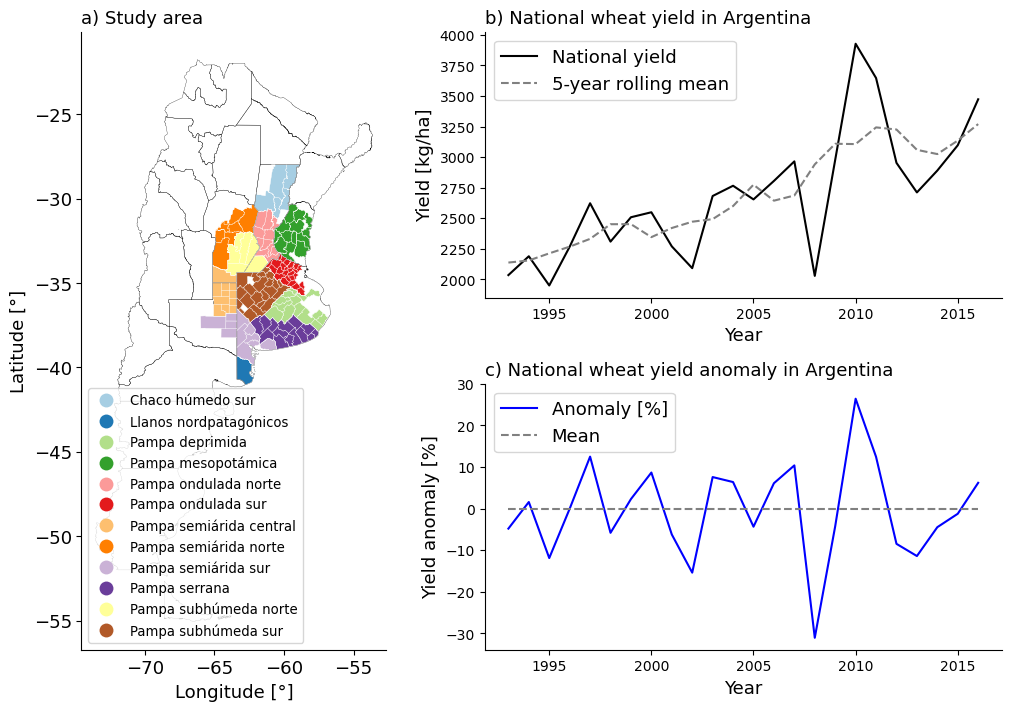

In [33]:

fontsize = 13
# Create subplots
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(10, 7), layout="constrained", width_ratios=[0.4, 0.6])

# Figure a) Study region
region_polygons.reset_index().plot(ax=axd["left"], column="region", cmap=my_cmap, edgecolor="white", linewidth=.2, legend=True, figsize=(3, 6), legend_kwds={"loc":"lower left", "fontsize":9.5})
gdf_adm1.plot(ax=axd["left"], color="#FF000000", edgecolor="black", linewidth=0.2)
gdf_adm2.plot(ax=axd["left"], color="#FF000000", edgecolor="white", linewidth=0.2)
axd["left"].set_title("a) Study area", loc="left", size=fontsize);
axd["left"].set_ylabel("Latitude [°]", size=fontsize);
axd["left"].set_xlabel("Longitude [°]", size=fontsize);
axd["left"].tick_params(axis='both', which='major', labelsize=fontsize)
axd["left"].spines[['right', 'top']].set_visible(False)

# b) National absolute yield and moving average
axd["upper right"].plot(df_national["year"], df_national["yield [kg/ha]"], label="National yield", color="black")
axd["upper right"].plot(df_national["year"], df_national["rolling_mean_yield"], label="5-year rolling mean", color="gray", linestyle="--")
axd["upper right"].set_xlabel("Year", fontsize=fontsize)
axd["upper right"].set_ylabel("Yield [kg/ha]", fontsize=fontsize)
axd["upper right"].legend(fontsize=fontsize)
axd["upper right"].set_title("b) National wheat yield in Argentina", loc="left", fontsize=fontsize)

# c) National yield variabilities
axd["lower right"].plot(df_national["year"], df_national["yield anomaly [%]"], label="Anomaly [%]", color="blue", linestyle="-")
axd["lower right"].plot([1993, 2016], [0, 0], color="gray", linestyle="--", label="Mean")
axd["lower right"].legend(fontsize=fontsize)
axd["lower right"].set_xlabel("Year", fontsize=fontsize)
axd["lower right"].set_yticks(np.arange(-30, 40, 10))
axd["lower right"].set_ylabel("Yield anomaly [%]", fontsize=fontsize)
axd["lower right"].set_title("c) National wheat yield anomaly in Argentina", loc="left", fontsize=fontsize)

#plt.savefig("files/figures/figure1.svg")

In [34]:
df_regional

,region,year,harvested area [ha],yield [kg/ha],rolling_mean_yield,yield anomaly [%],harvested area loo [ha]
0,Chaco húmedo sur,1993,37000,1913.756757,1882.869454,1.640438,64047.0
1,Chaco húmedo sur,1994,46800,1974.519231,1851.359850,6.652374,63639.0
2,Chaco húmedo sur,1995,32300,1000.012384,1540.477858,-35.084274,64243.0
3,Chaco húmedo sur,1996,71750,1750.388153,1576.835220,11.006409,62599.0
4,Chaco húmedo sur,1997,47000,1063.712766,1611.954994,-34.011013,63630.0
...,...,...,...,...,...,...,...
283,Pampa subhúmeda sur,2012,256100,2963.566068,3645.679417,-18.710185,487275.0
284,Pampa subhúmeda sur,2013,282710,3524.745853,3454.747313,2.026155,486166.0
285,Pampa subhúmeda sur,2014,521020,3420.920924,3543.265407,-3.452874,476236.0
286,Pampa subhúmeda sur,2015,337140,3538.226167,3800.086293,-6.890899,483898.0


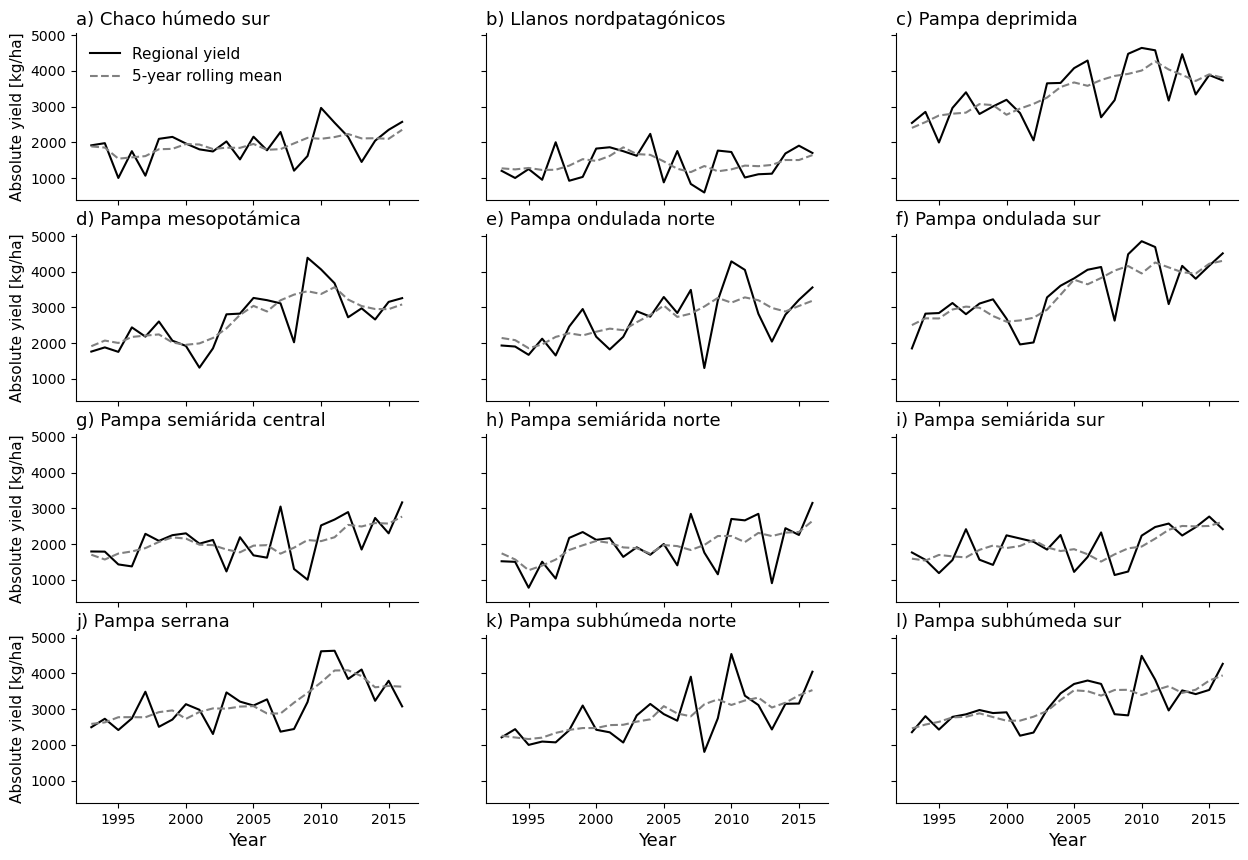

In [48]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.ravel()
list_of_counter = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)", "j)", "k)", "l)"]
counter = 0
for ax, region in zip(axs, df_regional["region"].unique()):
    data = df_regional[df_regional["region"] == region]
    sns.lineplot(data=data, x="year", y="yield [kg/ha]", label="Regional yield", ax=ax, color="black")
    sns.lineplot(data=data, x="year", y="rolling_mean_yield", label="5-year rolling mean", ax=ax, color="grey", linestyle="--")
    ax.set_title("{} {}".format(list_of_counter[counter], region), loc="left", fontsize=13)
    ax.set_xlabel("Year", fontsize=13)
    ax.set_ylabel("Absolute yield [kg/ha]", fontsize=11)
    ax.legend()
    ax.get_legend().remove()
    if region == "Chaco húmedo sur":
        ax.legend(loc="upper left", frameon=False, fontsize=11)
    counter += 1
    

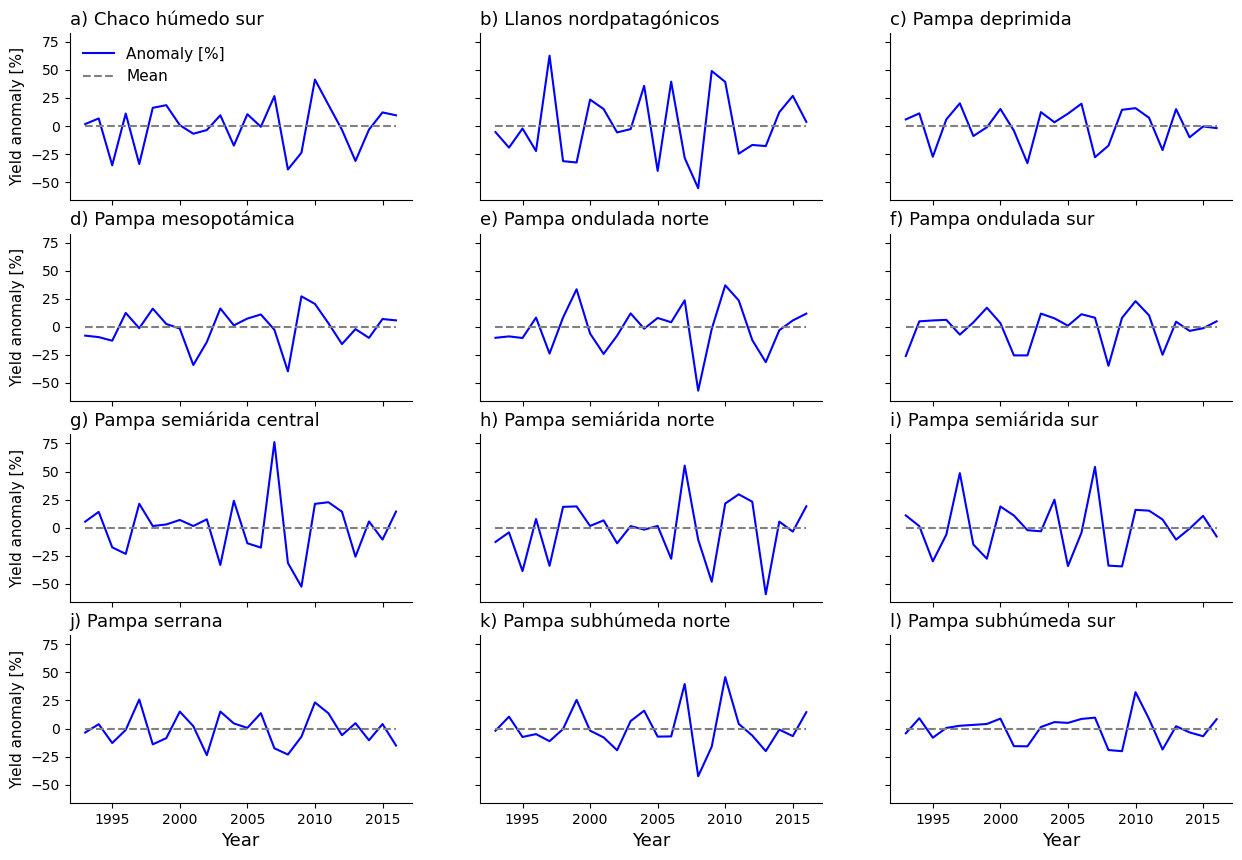

In [50]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.ravel()
list_of_counter = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)", "j)", "k)", "l)"]
counter = 0
for ax, region in zip(axs, df_regional["region"].unique()):
    data = df_regional[df_regional["region"] == region]
    sns.lineplot(data=data, x="year", y="yield anomaly [%]", label="Anomaly [%]", ax=ax, color="blue")
    ax.plot([1993, 2016], [0, 0], color="gray", linestyle="--", label="Mean")
    ax.set_title("{} {}".format(list_of_counter[counter], region), loc="left", fontsize=13)
    ax.set_xlabel("Year", fontsize=13)
    ax.set_ylabel("Yield anomaly [%]", fontsize=11)
    ax.legend()
    ax.get_legend().remove()
    if region == "Chaco húmedo sur":
        ax.legend(loc="upper left", frameon=False, fontsize=11)
    counter += 1
    

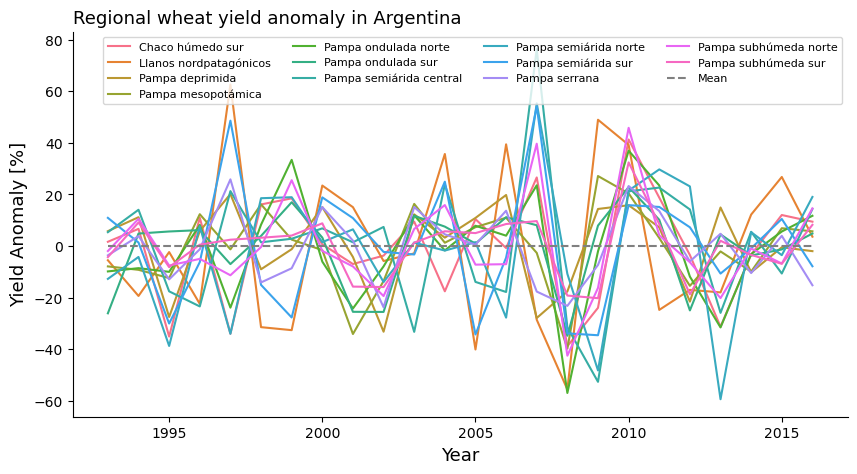

In [20]:
# Suppl. Material: Regional yield variabilities
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_regional, x="year", y="yield anomaly [%]", hue="region")
plt.plot([1993, 2016], [0, 0], color="gray", linestyle="--", label="Mean")
plt.title("Regional wheat yield anomaly in Argentina", loc="left", fontsize=13)
plt.xlabel("Year", fontsize=13)
plt.ylabel("Yield Anomaly [%]", fontsize=13)
plt.legend(fontsize=8, ncol=4)
plt.show()

### 8. EXPORT

In [32]:
df_regional.to_csv("files/crop data/regional_yield_iizumi.csv", index=False)
df_national.to_csv("files/crop data/national_yield_iizumi.csv", index=False)